
# **Setting up the Environment**

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import os
import glob
from keras.preprocessing import image
import imutils
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Menghubungkan ke google drive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# Mengambil dataset dari google drive

import zipfile  # library untuk mempercepat extract file
dataset_path = "/gdrive/My Drive/SKRIPSI/Dataset/Brain Tumor Dataset Testing 2.zip"
# dataset_path = "/gdrive/My Drive/SKRIPSI/Dataset/dataset-testing.zip"
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

In [4]:
IMG_PATH = "/content/Brain Tumor Dataset Testing"

# PREDICT

In [5]:
# Load the trained model
model = tf.keras.models.load_model("/gdrive/MyDrive/SKRIPSI/Result/InceptionResNetV2_Coba3/model_InceptionResNetV2_final.h5")

In [6]:
def crop_img(image):
    img = cv2.resize(
            image,
            dsize=(299,299),
            interpolation=cv2.INTER_CUBIC
        )
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # add contour on the image
    img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

    # add extreme points
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

    # crop
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img


In [7]:
# Define the class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Preprocess the input image
def preprocess_input(image):
    img = cv2.resize(
        image,
        dsize=(299, 299),
        interpolation=cv2.INTER_CUBIC
    )
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

Streaming output truncated to the last 5000 lines.
Image: /content/Brain Tumor Dataset Testing/meningioma/m (107).jpg
Predicted class: meningioma
1/1 [==============================] - 0s 39ms/step
Image: /content/Brain Tumor Dataset Testing/meningioma/m3 (207).jpg
Predicted class: meningioma
1/1 [==============================] - 0s 42ms/step
Image: /content/Brain Tumor Dataset Testing/meningioma/m (41).jpg
Predicted class: meningioma
1/1 [==============================] - 0s 43ms/step
Image: /content/Brain Tumor Dataset Testing/meningioma/m3 (66).jpg
Predicted class: meningioma
1/1 [==============================] - 0s 41ms/step
Image: /content/Brain Tumor Dataset Testing/meningioma/m3 (132).jpg
Predicted class: notumor
1/1 [==============================] - 0s 42ms/step
Image: /content/Brain Tumor Dataset Testing/meningioma/m3 (241).jpg
Predicted class: meningioma
1/1 [==============================] - 0s 40ms/step
Image: /content/Brain Tumor Dataset Testing/meningioma/m2 (46).jpg
P

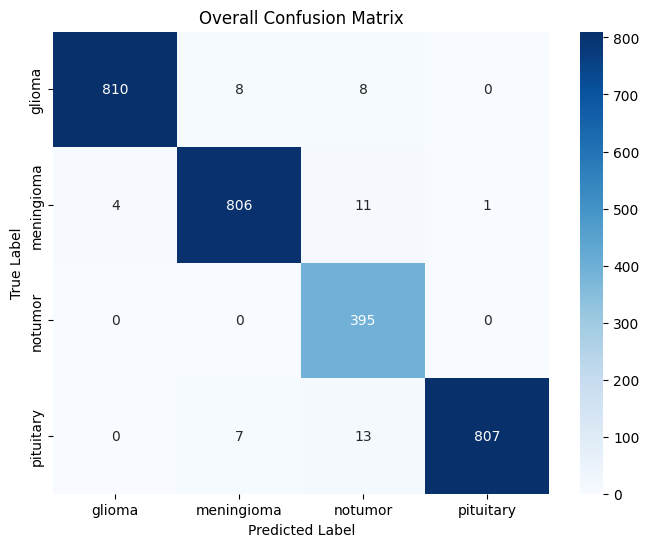


Class: glioma
Accuracy: 0.9930313588850174
Precision: 0.995085995085995
Sensitivity: 0.9806295399515739
Specificity: 0.9806295399515739
F1-Score: 0.9878048780487804
Confusion Matrix:
[[2040    4]
 [  16  810]]


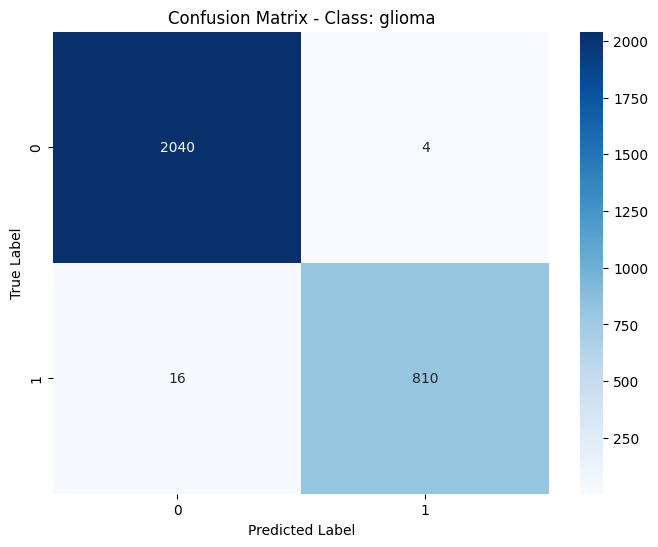


Class: meningioma
Accuracy: 0.989198606271777
Precision: 0.9817295980511571
Sensitivity: 0.9805352798053528
Specificity: 0.9805352798053528
F1-Score: 0.9811320754716981
Confusion Matrix:
[[2033   15]
 [  16  806]]


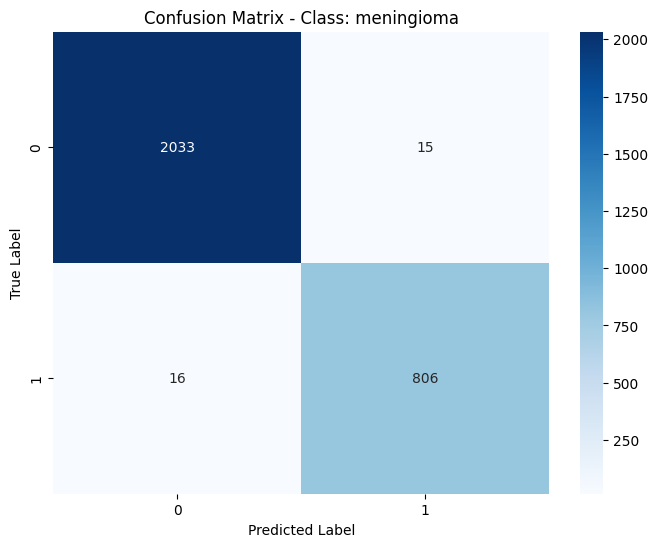


Class: notumor
Accuracy: 0.9888501742160278
Precision: 0.9250585480093677
Sensitivity: 1.0
Specificity: 1.0
F1-Score: 0.9610705596107056
Confusion Matrix:
[[2443   32]
 [   0  395]]


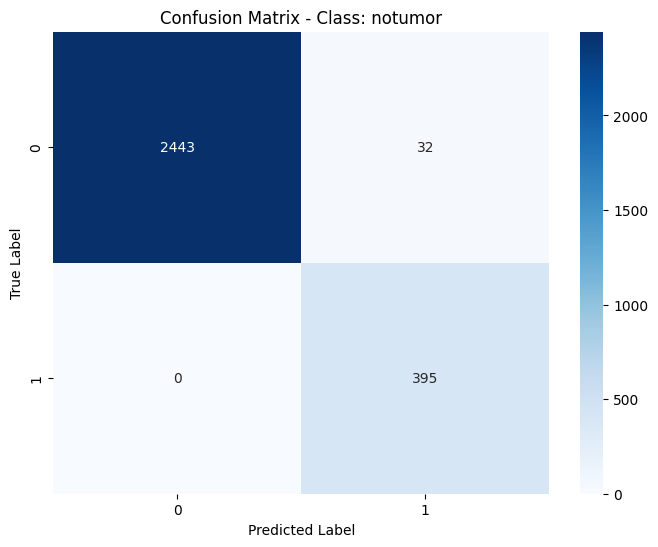


Class: pituitary
Accuracy: 0.9926829268292683
Precision: 0.9987623762376238
Sensitivity: 0.9758162031438936
Specificity: 0.9758162031438936
F1-Score: 0.9871559633027522
Confusion Matrix:
[[2042    1]
 [  20  807]]


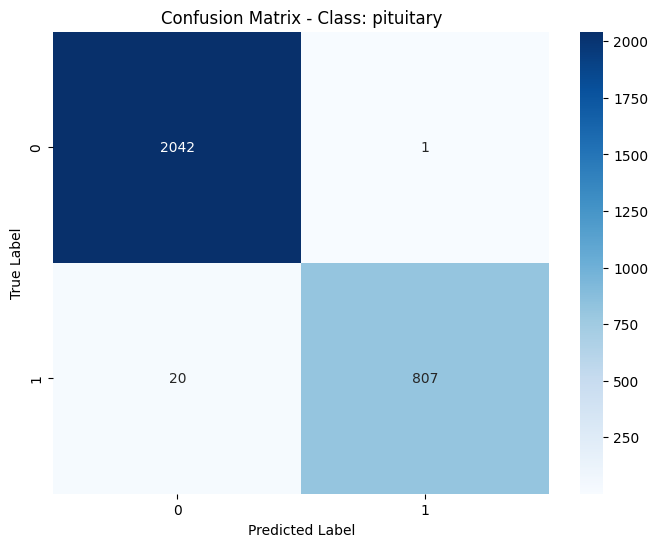

In [8]:
# Initialize lists for true labels and predicted labels
true_labels = []
predicted_labels = []

# Initialize dictionaries for per-class evaluation metrics and confusion matrices
per_class_accuracy = {}
per_class_precision = {}
per_class_sensitivity = {}
per_class_specificity = {}
per_class_f1 = {}
per_class_confusion_mat = {}

# Iterate over the folders in the data folder
for class_label in class_labels:
    folder_path = os.path.join(IMG_PATH, class_label)
    images = glob.glob(os.path.join(folder_path, '*.jpg'))

    # Iterate over the images in the current folder
    for img_path in images:
        img = cv2.imread(img_path)
        img_crop = crop_img(img)
        img_preprocessed = preprocess_input(img_crop)
        pred = model.predict(img_preprocessed)
        predicted_class = class_labels[np.argmax(pred)]

        # Append the true label and predicted label to the lists
        true_labels.append(class_label)
        predicted_labels.append(predicted_class)

        print('Image:', img_path)
        print('Predicted class:', predicted_class)

# Calculate overall evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
confusion_mat = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

tn, fp, fn, tp = confusion_mat[0][0], confusion_mat[0][1], confusion_mat[1][0], confusion_mat[1][1]
specificity = tn / (tn + fp)


# Print the overall evaluation metrics and confusion matrix
print('Overall Accuracy:', accuracy)
print('Overall Precision:', precision)
print('Overall Sensitivity:', sensitivity)
print('Overall Specificity:', specificity)
print('Overall F1-Score:', f1)
print(confusion_mat)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Overall Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate per-class evaluation metrics and confusion matrices
for i, class_label in enumerate(class_labels):
    class_true_labels = [1 if label == class_label else 0 for label in true_labels]
    class_predicted_labels = [1 if label == class_label else 0 for label in predicted_labels]

    class_accuracy = accuracy_score(class_true_labels, class_predicted_labels)
    class_precision = precision_score(class_true_labels, class_predicted_labels)
    class_sensitivity = recall_score(class_true_labels, class_predicted_labels)
    class_specificity = confusion_mat[i, i] / (confusion_mat[i, i] + confusion_mat[i, :].sum() - confusion_mat[i, i])
    class_f1 = f1_score(class_true_labels, class_predicted_labels)
    class_confusion_mat = confusion_matrix(class_true_labels, class_predicted_labels)

    per_class_accuracy[class_label] = class_accuracy
    per_class_precision[class_label] = class_precision
    per_class_sensitivity[class_label] = class_sensitivity
    per_class_specificity[class_label] = class_specificity
    per_class_f1[class_label] = class_f1
    per_class_confusion_mat[class_label] = class_confusion_mat

    # Print the per-class evaluation metrics and confusion matrix
    print(f'\nClass: {class_label}')
    print('Accuracy:', class_accuracy)
    print('Precision:', class_precision)
    print('Sensitivity:', class_sensitivity)
    print('Specificity:', class_specificity)
    print('F1-Score:', class_f1)
    print('Confusion Matrix:')
    print(class_confusion_mat)

    # Plot the per-class confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(class_confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f'Confusion Matrix - Class: {class_label}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()